# Homework 3 Solutions

**Name**:

**ID**:

> **Due Date**
>
> Thursday, 10/03/23, 9:00pm

## Overview

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

In [1]:
using Random
using CSV
using DataFrames
using Plots
using LaTeXStrings
using Distributions

## Problems (Total: 30 Points)

### Problem 1 (30 points)

The first step is to write function(s) to implement the Streeter-Phelps
simulation. With two releases, we can turn this into a two-box model,
with the first box from the initial waste release ($x=0\ \text{km}$) to
the second release ($x=15\ \text{km}$), and the second from the second
release to the end of the domain ($x=50\ \text{km}$). As a result, our
lives will be easiest if we write a function to simulate each box with
appropriate initial conditions, which we can then call for each river
segment. An example of how this might look is below. Note that we need
to compute $B$ and $N$ as well to get the appropriate initial conditions
at the transition between boxes (and this might also help with
debugging).

``` julia
# mix_concentration: function to compute initial conditions by mixing inflow and new waste stream concentrations
# inputs:
#   - arguments ending in "_in" are inflow, those ending in "_st" are from the stream
#   - V is the volume (L/d), Q is the relevant concentration (mg/L); these should be Floats
# outputs:
#   - mixed concentration (a Float) in mg/L
function mix_concentration(V_in, Q_in, V_st, Q_st)
    Q_mix = ((V_in * Q_in) + (V_st * Q_st)) / (V_in + V_st)
    return Q_mix
end

# dissolved_oxygen: function to simulate dissolved oxygen concentrations for a given segment
# inputs:
#   - x: vector or range of downstream distances to simulate over
#   - C₀, B₀, N₀: initial conditions for DO, CBOD, and NBOD, respectively (mg/L)
#   - U: velocity of river (km/d)
#   - Cₛ = saturation oxygen concentration (mg/L)
#   - ka, kc, kn: reaeration, CBOD decay, and NBOD decay rates, respectively (d^{-1})
function dissolved_oxygen_analytic(x, C₀, B₀, N₀, U, Cₛ, ka, kc, kn)

    # initialize vectors for C, B, and N
    # the zeros function lets us define a vector of the appropriate length with values set to zero
    C = zeros(length(x))
    B = zeros(length(x))
    N = zeros(length(x))

    # compute α values for the simulation
    α₁ = exp.(-ka * x / U)
    α₂ = (kc / (ka - kc)) * (exp.(-kc * x / U) .- α₁)
    α₃ = (kn / (ka - kn)) * (exp.(-kn * x / U) .- α₁)

    # loop over values in x to calculate B, N, and C
    for (i, d) in pairs(x)
        B[i] = B₀ * exp(-kc * x[i] / U)
        N[i] = N₀ * exp(-kn * x[i] / U)
        C[i] = Cₛ * (1 - α₁[i]) + (C₀ * α₁[i]) - (B₀ * α₂[i]) - (N₀ * α₃[i])
    end

    return (C, B, N)
end
```

    dissolved_oxygen_analytic (generic function with 1 method)

1.  These will be vectors due to the broadcasting of `exp` and `-` over
    the `x` vector. We could also have computed the `α` values in the
    loop below for each value of `x`.
2.  `pairs(x)` lets us directly iterate over indices (`i`) and values
    (`d`) in the vector `x`, rather than only iterating over indices and
    needing to look up the values `d=x[i]`.
3.  While we don’t need `B` and `N` for this solution, returning this
    tuple can be useful for debugging.

Next, let’s simulate the concentrations. Hopefully this is intuitive,
but one critical thing is that we need to compute the initial segment
from $x=0$ to $15\ \text{km}$, not just to 14, as $x=15$ is the inflow
for the initial condition of the segment after the second waste stream.

> **Note**
>
> I initially wrote this out as a script to debug, but then reformulated
> it as a function with an optional parameters for treatment of the two
> waste streams to solve subsequent problems, which means I didn’t have
> to copy and paste everything, possibly introducing new bugs.

``` julia
# do_simulate: function to simulate dissolved oxygen concentrations over the entire river
# inputs:
#   - inflow: tuple with inflow properties: (Volume, DO, CBOD, NBOD)
#   - waste1: tuple with waste stream 1 properties: (Volume, DO, CBOD, NBOD)
#   - waste2: tuple with waste stream 2 properties: (Volume, DO, CBOD, NBOD)
#   - U: velocity of river (km/d)
#   - Cₛ = saturation oxygen concentration (mg/L)
#   - ka, kc, kn: reaeration, CBOD decay, and NBOD decay rates, respectively (d^{-1})
function do_simulate_analytic(inflow, waste1, waste2, U, Cₛ, ka, kc, kn)
    # set up ranges for each box/segment
    x₁ = 0:1:15
    x₂ = (15:1:50) .- 15

    V_inflow, C_inflow, B_inflow, N_inflow = inflow
    V_ws1, C_ws1, B_ws1, N_ws1 = waste1
    V_ws2, C_ws2, B_ws2, N_ws2 = waste2

    # initialize storage for final C, B, and N
    # need to store d=0 so the total length should be d+1
    C = zeros(51)
    B = zeros(51)
    N = zeros(51)

    # compute initial conditions for first segment
    C₀ = mix_concentration(V_inflow, C_inflow, V_ws1, C_ws1)
    B₀ = mix_concentration(V_inflow, B_inflow, V_ws1, B_ws1)
    N₀ = mix_concentration(V_inflow, N_inflow, V_ws1, N_ws1)

    # conduct first segment simulation
    (C₁, B₁, N₁) = dissolved_oxygen_analytic(x₁, C₀, B₀, N₀, U, Cₛ, ka, kc, kn)
    C[1:15] = C₁[1:end-1]
    B[1:15] = B₁[1:end-1]
    N[1:15] = N₁[1:end-1]

    # compute initial conditions for second segment
    C₀₁ = mix_concentration(V_inflow + V_ws1, C₁[end], V_ws2, C_ws2)
    B₀₁ = mix_concentration(V_inflow + V_ws1, B₁[end], V_ws2, B_ws2)
    N₀₁ = mix_concentration(V_inflow + V_ws1, N₁[end], V_ws2, N_ws2)

    # conduct second segment simulation
    (C₂, B₂, N₂) = dissolved_oxygen_analytic(x₂, C₀₁, B₀₁, N₀₁, U, Cₛ, ka, kc, kn)
    C[16:end] = C₂
    B[16:end] = B₂
    N[16:end] = N₂

    return (C, B, N)
end

# set variables for river dynamics
U = 6
Cₛ = 10
ka = 0.55
kc = 0.35
kn = 0.25

# set initial parameters
C_inflow = 7.5 # DO concentration
B_inflow = 5.0 # CBOD
N_inflow = 5.0 # NBOD
V_inflow = 100 * 1_000 # volume converted to L
inflow = (V_inflow, C_inflow, B_inflow, N_inflow)

# set waste stream parameters
C_ws1 = 5.0
B_ws1 = 50.0
N_ws1 = 35.0
V_ws1 = 10 * 1_000
waste1 = (V_ws1, C_ws1, B_ws1, N_ws1)

C_ws2 = 4.0
B_ws2 = 45.0
N_ws2 = 35.0
V_ws2 = 15 * 1_000
waste2 = (V_ws2, C_ws2, B_ws2, N_ws2)

C, B, N = do_simulate_analytic(inflow, waste1, waste2, U, Cₛ, ka, kc, kn)
```

    ([7.2727272727272725, 6.718366940001292, 6.252736478441488, 5.865982487427475, 5.549224625451668, 5.294464471079079, 5.094502688374758, 4.942863751725384, 4.8337275512230455, 4.761867260163488  …  5.965177734979926, 6.111409254214727, 6.254932119301499, 6.395478206784325, 6.532828783895545, 6.66680882593059, 6.797281903682192, 6.924145587090053, 7.047327316192408, 7.166780694952493], [9.090909090909092, 8.575776817031748, 8.089834281709308, 7.63142746153825, 7.198996057607107, 6.791068184640297, 6.4062553610792135, 6.043247783048131, 5.700809866118693, 5.377776039698319  …  1.916804331604075, 1.8081894764731885, 1.7057292332453498, 1.6090748536058688, 1.5178973509064155, 1.4318863803790853, 1.350749182802631, 1.274209588025372, 1.2020070749530312, 1.1338958848019383], [7.7272727272727275, 7.411918532206977, 7.109434113044771, 6.819294247244602, 6.540995146882018, 6.27405358389127, 6.018006051006311, 5.772407956944252, 5.536832854433826, 5.3108716997484215  …  2.653493696687388, 2.5452031783680957, 2.4413320548913466, 2.3416999683543676, 2.246133921358312, 2.1544679766220987, 2.0665429688551744, 1.9822062283889013, 1.9013113160867028, 1.8237177690726656])

1.  The colon syntax sets up the range using the syntax
    `initial_value:stepsize:end_value`. In general a stepsize of 1 is
    implicit, but I’ve made it explicit here for illustration.
2.  This starts at 0 because we care about the distance from the initial
    condition, not the “absolute” distance.
3.  Tuples (including multiple outputs from functions) can be unpacked
    into multiple variables this way to make the subsequent code more
    readable (versus just relying on indexing).
4.  We don’t need to store the last value because that occurs at the
    point of mixing with the next waste stream. We will use it to
    compute the mixed concentration at that point.

Now we can plot the dissolved oxygen concentration, shown in
<a href="#fig-do-untreated" class="quarto-xref">Figure 1</a>.

``` julia
# create plot axis with labels, etc
p = plot(; xlabel="Distance Downriver (km)", ylabel="Dissolved Oxygen Concentration (mg/L)", legend=:top)
plot!(p, 0:50, C, color=:blue, label="Analytic Solution")
hline!(p, [4], color=:black, linestyle=:dot, label="Regulatory Standard")
```

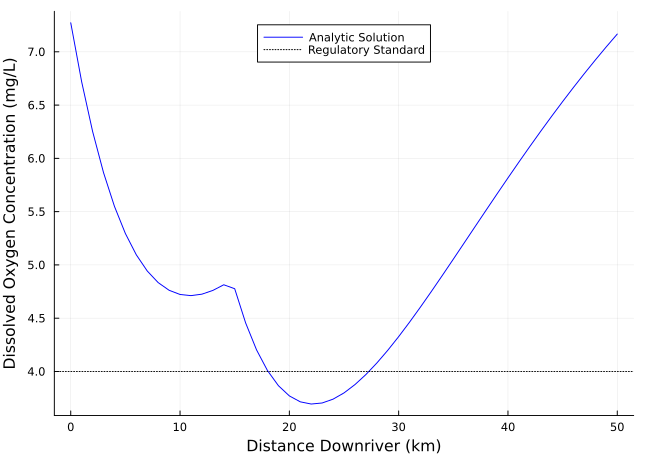

Figure 1: Simulated dissolved oxygen concentration for Problem 1 without
treatment.

1.  These lines of code separate the creation of the plot axis (with
    labels, legend positions, etc) using `p = plot(...)` from the
    plotting of the data with `plot!(p, ...)`. You can do this all in a
    single `plot()` call, but this may sometimes make things more
    readable when there are a lot of style arguments for the axes.

We can see that the DO concentration falls below the regulatory standard
of 4 mg/L before 20 km downstream. To find the minimum value, we can use
the `minimum()` function.

``` julia
@show minimum(C);
```

    minimum(C) = 3.694312052808094

So the minimum value is 3.7 mg/L.

### Problem 1.2

Instead of the analytic Streeter-Phelps equation, now we want to use a
numerically-integrated solution to the DO equation (“neglecting” $P$,
$R$, and $S_B$ by combining with the other constant terms):

$$
\begin{aligned}
C(x+\Delta x) &= C(x) + \frac{\Delta x}{U}(k_a (C_s - C(x)) + P - R - S_B \\
    &\quad - k_cB(x) - k_n N(x)) \\[0.5em]
B(x + \Delta x) &= B(x)\exp\left(\frac{-k_c\Delta x}{U}\right) \\
N(x + \Delta x) &= N(x)\exp\left(\frac{-k_n\Delta x}{U}\right)
\end{aligned}
$$

One implementation of this solution:

``` julia
# do_numerical: function to numerically simulate dissolved oxygen concentrations over a single box
# inputs:
#   - L: length of the river segment corresponding to the box
#   - Δx: spatial resolution (length step) in km
#   - C0: initial DO concentration of the box (after any mixing has occurred) in mg/L
#.  - B0: initial CBOD concentration of the box (after any mixing has occurred) in mg/L
#.  - N0: initial NBOD concentration of the box (after any mixing has occurred) in mg/L
#   - ka, kc, kn: reaeration, CBOD decay, and NBOD decay rates, respectively (d^{-1})
#   - Cₛ = saturation oxygen concentration (mg/L)
#   - U: velocity of river (km/d)
function do_numerical(L, Δx, C0, B0, N0, ka, kc, kn, Cs, U)
    n = Int(L / Δx) # number of length steps
    C = zeros(n + 1)
    B = zeros(n + 1)
    N = zeros(n + 1)
    C[1] = C0
    B[1] = B0
    N[1] = N0
    for i = 1:n
        B[i+1] = B[i] * exp(-kc * Δx / U)
        N[i+1] = N[i] * exp(-kn * Δx / U)
        C[i+1] = C[i] + (Δx / U) * (ka * (Cs - C[i]) - kc * B[i] - kn * N[i])
    end
    return (C, B, N)
end

# do_simulate_numerical: function to numerically simulate dissolved oxygen concentrations over the entire river
# inputs:
#   - L: tuple with lengths of each box (in km from the first waste discharge)
#.  - Δx: spatial resolution of simulation (in km)
#   - inflow: tuple with inflow properties: (Volume, DO, CBOD, NBOD)
#   - waste1: tuple with waste stream 1 properties: (Volume, DO, CBOD, NBOD)
#   - waste2: tuple with waste stream 2 properties: (Volume, DO, CBOD, NBOD)
#   - U: velocity of river (km/d)
#   - Cₛ = saturation oxygen concentration (mg/L)
#   - ka, kc, kn: reaeration, CBOD decay, and NBOD decay rates, respectively (d^{-1})
function do_numerical_simulate(L, Δx, inflow, waste1, waste2, U, Cₛ, ka, kc, kn)
    # set up ranges for each box/segment
    L1, L2 = L
    x₁ = 0:Δx:L1
    x₂ = 0:Δx:L2

    V_inflow, C_inflow, B_inflow, N_inflow = inflow
    V_ws1, C_ws1, B_ws1, N_ws1 = waste1
    V_ws2, C_ws2, B_ws2, N_ws2 = waste2

    # initialize storage for final C, B, and N
    # need to store d=0 so the total length should be n+1
    n = Int(sum(L) / Δx)
    C = zeros(n + 1)
    B = zeros(n + 1)
    N = zeros(n + 1)

    # compute initial conditions for first segment
    C₀ = mix_concentration(V_inflow, C_inflow, V_ws1, C_ws1)
    B₀ = mix_concentration(V_inflow, B_inflow, V_ws1, B_ws1)
    N₀ = mix_concentration(V_inflow, N_inflow, V_ws1, N_ws1)

    # conduct first segment simulation
    (C₁, B₁, N₁) = do_numerical(L1, 0.5, C₀, B₀, N₀, ka, kc, kn, Cₛ, U)
    C[1:length(C₁)-1] = C₁[1:end-1]
    B[1:length(B₁)-1] = B₁[1:end-1]
    N[1:length(N₁)-1] = N₁[1:end-1]

    # compute initial conditions for second segment
    C₀₁ = mix_concentration(V_inflow + V_ws1, C₁[end], V_ws2, C_ws2)
    B₀₁ = mix_concentration(V_inflow + V_ws1, B₁[end], V_ws2, B_ws2)
    N₀₁ = mix_concentration(V_inflow + V_ws1, N₁[end], V_ws2, N_ws2)

    # conduct second segment simulation
    (C₂, B₂, N₂) = do_numerical(L2, 0.5, C₀₁, B₀₁, N₀₁, ka, kc, kn, Cₛ, U)
    C[length(C₁):end] = C₂
    B[length(B₁):end] = B₂
    N[length(N₁):end] = N₂

    return (C, B, N)
end

C1, B1, N1 = do_numerical_simulate((15, 35), 0.5, inflow, waste1, waste2, U, Cₛ, ka, kc, kn)
```

    ([7.2727272727272725, 6.971590909090909, 6.6951976781381255, 6.442125991305724, 6.211027125093855, 6.000621671288766, 5.809696155687461, 5.637099817439324, 5.481741541485681, 5.342586936927337  …  6.586186577438842, 6.653823980453237, 6.720542279075113, 6.786328586618889, 6.851172030049296, 6.9150636200486915, 6.977996128054285, 7.039963969918068, 7.100963095858886, 7.160990886391999], [9.090909090909092, 8.829587047397027, 8.575776817031747, 8.329262469553433, 8.089834281709306, 7.8572885588305805, 7.631427461538247, 7.412058837430288, 7.198996057607104, 6.992057857896094  …  1.4742647467725687, 1.4318863803790842, 1.390726198129331, 1.3507491828026297, 1.311921323763184, 1.2742095880253705, 1.2375818921507704, 1.20200707495303, 1.1674548709873347, 1.133895884801937], [7.7272727272727275, 7.567953219377766, 7.411918532206978, 7.259100939922314, 7.109434113044772, 6.96285308966452, 6.819294247244604, 6.678695275005998, 6.540995146882022, 6.406134095030371  …  2.199823539462004, 2.154467976622107, 2.1100475465524626, 2.0665429688551824, 2.0239353606521258, 1.9822062283889093, 1.9413374598079005, 1.9013113160867106, 1.8621104241387738, 1.8237177690726731])

Now let’s add this simulation to the plot from Problem 1.1:

``` julia
plot!(p, 0:0.5:50, C1, color=:darkorange, label="Numerical Solution")
```

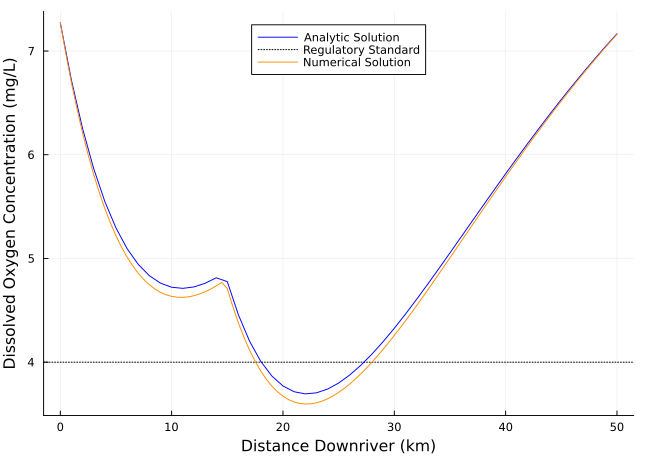

Figure 2: Numerical and analytic DO solutions for Problem 1.

The minimum value is 3.6 mg/L. What is the cause of the difference? At
each length step, the values of `C`, `B`, and `N` are taken from the
previous step, 0.5 km away. Prior to the DO rebound, this means that the
corresponding CBOD and NBOD values, and therefore the level of
deoxygenation, are higher than in the analytic solution. At the same
time, the level of dissolved oxygen is greater than in the analytic
solution, so there is reduced reaeration. The combined effect is that
the DO reduces more quickly than in the analytic solution at each step,
and the minimum is lower. Conversely, once the minimum is reached and
reaeration begins to dominate, because the DO level is lower, there is a
more aggressive reaeration, and the numerical solution can catch up as
the CBOD and NBOD become more negligible downstream.

### Problem 1.3

To determine the minimum treatment of the waste streams needed to
maintain compliance, we will write a function which will apply treatment
levels `eff1` and `eff2` and evaluate our function above, returning the
minimum DO concentration.

``` julia
# waste_treat: function to simulate DO with treated discharges; treatments apply to CBOD and NBOD released
# inputs:
#   - eff1: efficiency of treatment for waste stream 1 (as a decimal)
#   - eff2: efficiency of treatment for waste stream 2 (as a decimal)
#   - inflow: tuple with inflow properties: (Volume, DO, CBOD, NBOD)
#   - waste1: tuple with waste stream 1 properties: (Volume, DO, CBOD, NBOD)
#   - waste2: tuple with waste stream 2 properties: (Volume, DO, CBOD, NBOD)
#   - U: velocity of river (km/d)
#   - Cₛ = saturation oxygen concentration (mg/L)
#   - ka, kc, kn: reaeration, CBOD decay, and NBOD decay rates, respectively (d^{-1})
function waste_treat(eff1, eff2, inflow, waste1, waste2, U, Cₛ, ka, kc, kn)
    waste1_treated = (waste1[1], waste1[2], (1 - eff1) * waste1[3], (1 - eff1) * waste1[4])    
    waste2_treated = (waste2[1], waste2[2], (1 - eff2) * waste2[3], (1 - eff2) * waste2[4])    
    C, B, N = do_simulate_analytic(inflow, waste1_treated, waste2_treated, U, Cₛ, ka, kc, kn)
    return minimum(C)
end
```

    waste_treat (generic function with 1 method)

Now we can evaluate this function over a range of treatment
efficiencies. There are a number of ways to do this, but we’ll use a
trick which Julia makes easy: broadcasting using an anonymous function.

``` julia
# evaluate treatment efficiencies between 0 and 1
effs = 0:0.01:1
treat1 = (e1 -> waste_treat(e1, 0, inflow, waste1, waste2, U, Cₛ, ka, kc, kn)).(effs)
treat2 = (e2 -> waste_treat(0, e2, inflow, waste1, waste2, U, Cₛ, ka, kc, kn)).(effs)
```

    101-element Vector{Float64}:
     3.694312052808094
     3.715106569604958
     3.7359010864018223
     3.7566956031986853
     3.7774901199955497
     3.7982846367924123
     3.819079153589276
     3.8398736703861394
     3.8606681871830038
     3.8814627039798673
     ⋮
     4.711700098308851
     4.711700098308851
     4.711700098308851
     4.711700098308851
     4.711700098308851
     4.711700098308851
     4.711700098308851
     4.711700098308851
     4.711700098308851

To find the minimum treatment level which ensures compliance, we can now
find the position of the first value where the minimum value is at least
4.2 mg/L, and look up the associated efficiency. Julia provides the
`findfirst()` function which lets you find the index of the first value
satisfying a Boolean condition.

``` julia
# find indices and treatment values
idx1 = findfirst(treat1 .>= 4.2)
idx2 = findfirst(treat2 .>= 4.2)
@show effs[idx1];
@show effs[idx2];
```

    effs[idx1] = 0.32
    effs[idx2] = 0.26

So the minimum treatment level for waste stream 1 is 32% and the minimum
treatment level for waste stream 2 is 26%.

### Problem 1.4

There is no “right” answer to the question of which treatment option you
would pick, so long as your solution is thoughtful and justified.

-   For example, one could argue that as waste stream 1 on its own does
    not result in a lack of compliance (which we can see from
    <a href="#fig-do-untreated" class="quarto-xref">Figure 1</a>, as the
    initial “sag” has started to recover prior to waste stream 2), waste
    stream 2 ought to be treated.
-   On the other hand, waste stream 1 has a much more negative impact on
    the inflow dissolved oxygen levels, and waste stream 2 might not
    cause a lack of compliance without that effect, which might suggest
    that waste stream 1 should be treated.
-   Another consideration might be the relative cost of treating each
    waste stream, which we have no information on, or whether these
    waste streams are from municipal, residual, or industrial sources
    (in other words, non-profit vs. profit).

### Problem 1.5

To conduct this Monte Carlo experiment, we need to draw samples from the
given $\text{LogNormal}(2.0, 0.15)$ distribution. We’ll start by drawing
5,000 samples and see if this is sufficient; your answer may be
different if this was more or less than you drew.

``` julia
nsamp = 5_000
samps = rand(LogNormal(2.0, 0.15), nsamp)
histogram(samps, xlabel="River Inflow DO Concentrations (mg/L)", ylabel="Count")
```

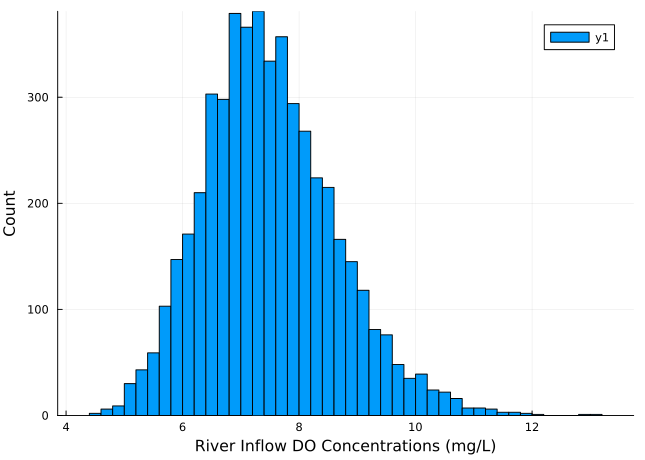

Figure 3: Samples drawn from the LogNormal(2.0, 0.15) distribution.

Now we need to evaluate our model for each of these, using the same
`eff1` value that we obtained in Problem 1.3, and we will save the
statistic that we are interested in, which is whether the DO falls below
the regulatory limit.

``` julia
compliance = zeros(nsamp)
for i = 1:nsamp
    inflow = (V_inflow, samps[i], B_inflow, N_inflow) # this changes the inflow tuple to have the sampled DO level
    do_out = waste_treat(effs[idx1], 0, inflow, waste1, waste2, U, Cₛ, ka, kc, kn)
    compliance[i] = minimum(do_out) > 4.0
end
```

Now we can compute the Monte Carlo estimate as a function of the sample
size and the confidence interval.

``` julia
mc_est = zeros(nsamp)
mc_se = zeros(nsamp)
for i = 1:nsamp
    if i == 1
        mc_est[i] = compliance[i]
        mc_se[i] = 0
    else
        mc_est[i] = (mc_est[i-1] * (i-1) + compliance[i]) / i
        mc_se[i] = std(compliance[1:i]) / sqrt(i)
    end
end

plot(mc_est, ribbon=1.96 * mc_se, ylabel="Compliance Probability", xlabel="Sample", label="Monte Carlo Estimate")
```

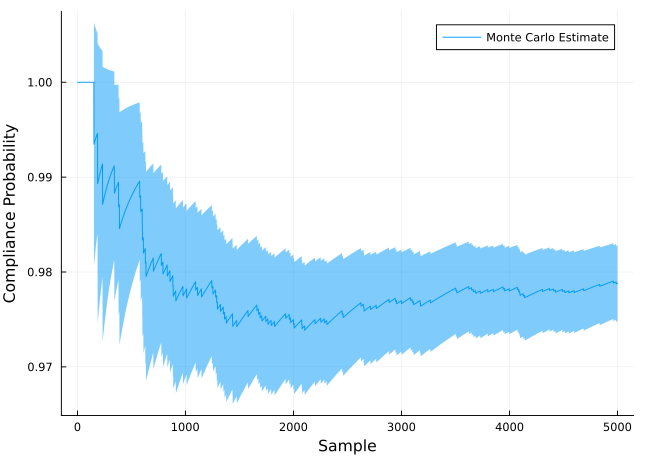

Figure 4: Results from the Monte Carlo simulation in Problem 1.

The Monte Carlo estimate of the compliance probability is about 98%,
with a 95% confidence interval of (97%, 98%) (obtained by getting a
half-width of the confidence interval of $1.96 \times \text{SE}$), where
$\text{SE}$ is the Monte Carlo standard error.

We can see that this estimate has stabilized after about 2,000 samples,
so our use of 5,000 can be justified so long as the level of uncertainty
is appropriate for a given decision. For example, if any failure under
these conditions is intolerable, we would not even need this many
simulations, as before 1,000 simulations it becomes clear that this
failure will occur. If there is some other standard, then we would have
to compare that to the confidence interval to see if our decision would
be ihfluenced by further refinement of the estimate.

## References

List any external references consulted, including classmates.